# Installing and importing libraries

In [ ]:
#installing library
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 927.7 kB/s eta 0:00:00


In [ ]:
#importing libraries
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
import io
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, median_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import joblib

# Scraping data from api ergast

In this section, we are retrieving detailed data about F1 races using the Ergast API.
Specifically, we are gathering information about drivers, their performance in each race, the years in which these races occurred, and the status of each driver at the end of the race (e.g., 'Finished', 'Accident', 'Retired').
This data provides insights into various factors that can influence race outcomes, such as the driver's consistency, mechanical reliability, and race incidents.
By scraping this data for multiple years, we ensure that our dataset is comprehensive and includes a wide range of scenarios and variables.
Each API request retrieves race results for a specific year and round, and we aggregate this data to form a complete historical record.


In [ ]:


years = list(range(2015, 2025))
all_data = pd.DataFrame()

for year in years:
    for round_num in range(1, 23):
        url = f'http://ergast.com/api/f1/{year}/{round_num}/results.json'
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            races = data['MRData']['RaceTable']['Races']
            if races:
                # Extract Drivers Data
                results = races[0].get('Results', [])
                df_drivers = pd.json_normalize(results)

                # Extract Circuits Data
                circuit_info = races[0].get('Circuit', {})
                df_circuits = pd.json_normalize(circuit_info)

                #Combine the data
                combined_df = pd.concat([df_drivers, df_circuits], axis=1)

                combined_df['Year'] = year
                combined_df['Round'] = round_num

                all_data = pd.concat([all_data, combined_df], ignore_index=True)

# Saving it in a CSV file
all_data.to_csv('f1_drivers_results_circuits_2015_2024.csv', index=False)


In [ ]:
#downloading the resultant csv file on local device
files.download('f1_drivers_results_circuits_2015_2024.csv')

In [ ]:
uploaded = files.upload()
filename = next(iter(uploaded))

Saving f1_drivers_results_circuits_2015_2024.csv to f1_drivers_results_circuits_2015_2024 (1).csv


In [ ]:
#reading the csv file
dataframe1 = pd.read_csv(io.BytesIO(uploaded[filename]))
dataframe1

,number,position,positionText,points,grid,laps,status,Driver.driverId,Driver.permanentNumber,Driver.code,...,FastestLap.AverageSpeed.speed,circuitId,url,circuitName,Location.lat,Location.long,Location.locality,Location.country,Year,Round
0,44,1,1,25.0,1,58,Finished,hamilton,44,HAM,...,209.915,albert_park,http://en.wikipedia.org/wiki/Melbourne_Grand_P...,Albert Park Grand Prix Circuit,-37.8497,144.968,Melbourne,Australia,2015,1
1,6,2,2,18.0,2,58,Finished,rosberg,6,ROS,...,209.577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,1
2,5,3,3,15.0,4,58,Finished,vettel,5,VET,...,208.740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,1
3,19,4,4,12.0,3,58,Finished,massa,19,MAS,...,208.144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,1
4,12,5,5,10.0,10,58,Finished,nasr,12,NAS,...,206.137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4014,22,16,16,0.0,20,44,Finished,tsunoda,22,TSU,...,233.533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,14
4015,2,17,17,0.0,18,44,Finished,sargeant,2,SAR,...,234.574,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,14
4016,27,18,18,0.0,16,44,Finished,hulkenberg,27,HUL,...,231.422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,14
4017,24,19,R,0.0,19,5,Retired,zhou,24,ZHO,...,224.929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,14


# Understanding the data

In this section, we explore the dataset to get an overview of its structure and content.
1. Printing the first few rows to see the actual data entries.
2. Checking all the unique columns.
3. Checking the size and shape of the dataset to understand its dimensions.
3. Use describe function to generate descriptive statistics, giving insights into the distribution of numerical features.
5. Identifing columns with missing values to plan for data cleaning and imputation.
6. Examining categorical columns to understand the variety of categories and potential for encoding.
7. Checking for duplicate codes.
This initial exploration helps in understanding the data types, distributions, and any anomalies, guiding the next steps in the preprocessing pipeline.


In [ ]:
# print all the columns of our dataframe

print(dataframe1.columns)

Index(['number', 'position', 'positionText', 'points', 'grid', 'laps',
       'status', 'Driver.driverId', 'Driver.permanentNumber', 'Driver.code',
       'Driver.url', 'Driver.givenName', 'Driver.familyName',
       'Driver.dateOfBirth', 'Driver.nationality', 'Constructor.constructorId',
       'Constructor.url', 'Constructor.name', 'Constructor.nationality',
       'Time.millis', 'Time.time', 'FastestLap.rank', 'FastestLap.lap',
       'FastestLap.Time.time', 'FastestLap.AverageSpeed.units',
       'FastestLap.AverageSpeed.speed', 'circuitId', 'url', 'circuitName',
       'Location.lat', 'Location.long', 'Location.locality',
       'Location.country', 'Year', 'Round'],
      dtype='object')


In [ ]:
# checking the size, shape of our dataframe

print(dataframe1.size)
print(dataframe1.shape)

140665
(4019, 35)


In [ ]:
print(dataframe1.describe)

<bound method NDFrame.describe of       number  position positionText  points  grid  laps        status  \
0         44         1            1    25.0     1    58      Finished   
1          6         2            2    18.0     2    58      Finished   
2          5         3            3    15.0     4    58      Finished   
3         19         4            4    12.0     3    58      Finished   
4         12         5            5    10.0    10    58      Finished   
...      ...       ...          ...     ...   ...   ...           ...   
4014      22        16           16     0.0    20    44      Finished   
4015       2        17           17     0.0    18    44      Finished   
4016      27        18           18     0.0    16    44      Finished   
4017      24        19            R     0.0    19     5       Retired   
4018      63        20            D     0.0     6    44  Disqualified   

     Driver.driverId  Driver.permanentNumber Driver.code  ...  \
0           hamilton    

In [ ]:
# finding the null values in our datasets

dataframe1.isnull().sum()

,0
number,0
position,0
positionText,0
points,0
grid,0
laps,0
status,0
Driver.driverId,0
Driver.permanentNumber,0
Driver.code,0


In [ ]:
# checking which columns are categorical and need encoding

categorical_cols = dataframe1.select_dtypes(include=['object']).columns.tolist()
categorical_cols

['positionText',
 'status',
 'Driver.driverId',
 'Driver.code',
 'Driver.url',
 'Driver.givenName',
 'Driver.familyName',
 'Driver.dateOfBirth',
 'Driver.nationality',
 'Constructor.constructorId',
 'Constructor.url',
 'Constructor.name',
 'Constructor.nationality',
 'Time.time',
 'FastestLap.Time.time',
 'FastestLap.AverageSpeed.units',
 'circuitId',
 'url',
 'circuitName',
 'Location.locality',
 'Location.country']

In [ ]:
# Check for duplicate rows

duplicate_rows = dataframe1[dataframe1.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")

if duplicate_rows.shape[0] > 0:
    print("Duplicates found:")
    print(duplicate_rows.head())
else:
    print("No duplicate rows found.")


Number of duplicate rows: 0
No duplicate rows found.


# **EDA**

# **Data cleaning and preprocessing**

1. Adding a column for the Grand Prix (GP) names
2. Filling null values which require only firward fill
3. Dropping  columns
4. Combining columns
5. Filling null values for the rest of the columns


1.
The original dataset contains information about the races, but it only includes the country where each Grand Prix (GP) took place.
However, for our analysis, it's useful to have the specific GP name (e.g., "Monaco GP", "British GP") rather than just the country.
This is because multiple GPs can occur in the same country (e.g., "Italian GP" and "Emilia Romagna GP" both occur in Italy).
To accurately reflect the event details, we use a mapping technique to associate each country with its corresponding GP name.
This allows us to add a new column, 'GP', to the dataset, ensuring that we have more specific and meaningful event identifiers for our analysis.


In [ ]:
# checking the unique values of the column "location.country"
# to find out all the countries that we have

print(dataframe1['Location.country'].unique())

['Australia' nan 'Malaysia' 'China' 'Bahrain' 'Spain' 'Monaco' 'Canada'
 'Austria' 'UK' 'Hungary' 'Belgium' 'Italy' 'Singapore' 'Japan' 'Russia'
 'USA' 'Mexico' 'Brazil' 'UAE' 'Azerbaijan' 'Germany' 'France' 'Portugal'
 'Turkey' 'Netherlands' 'Qatar' 'Saudi Arabia' 'United States']


In [ ]:
# Mapping of country names to F1 GP names
gp_mapping = {
    'Australia': 'Australian Grand Prix',
    'Malaysia': 'Malaysian Grand Prix',
    'China': 'Chinese Grand Prix',
    'Bahrain': 'Bahrain Grand Prix',
    'Spain': 'Spanish Grand Prix',
    'Monaco': 'Monaco Grand Prix',
    'Canada': 'Canadian Grand Prix',
    'Austria': 'Austrian Grand Prix',
    'UK': 'British Grand Prix',
    'Hungary': 'Hungarian Grand Prix',
    'Belgium': 'Belgian Grand Prix',
    'Italy': 'Italian Grand Prix',
    'Singapore': 'Singapore Grand Prix',
    'Japan': 'Japanese Grand Prix',
    'Russia': 'Russian Grand Prix',
    'USA': 'United States Grand Prix',
    'Mexico': 'Mexican Grand Prix',
    'Brazil': 'Brazilian Grand Prix',
    'UAE': 'Abu Dhabi Grand Prix',
    'Azerbaijan': 'Azerbaijan Grand Prix',
    'Germany': 'German Grand Prix',
    'France': 'French Grand Prix',
    'Portugal': 'Portuguese Grand Prix',
    'Turkey': 'Turkish Grand Prix',
    'Netherlands': 'Dutch Grand Prix',
    'Qatar': 'Qatar Grand Prix',
    'Saudi Arabia': 'Saudi Arabian Grand Prix',
    'United States': 'United States Grand Prix'
}

# Adding a new column 'racename' to the DataFrame
dataframe1['racename'] = dataframe1['Location.country'].map(gp_mapping)

2. Some columns in the dataset have missing values that can be logically filled by carrying forward the previous non-null value. We use the forward fill method (`ffill`) to propagate the last valid observation forward. This is particularly useful for columns where the data is missing due to sequential recording.


In [ ]:
# List of columns to forward fill
columns_to_fill = ['Location.lat', 'Location.long', 'Location.locality', 'Location.country', 'racename', 'circuitId', 'circuitName']

# Forward fill the NaN values in the specified columns
dataframe1[columns_to_fill] = dataframe1[columns_to_fill].fillna(method='ffill')



<ipython-input-90-7f85ae4753d2>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataframe1[columns_to_fill] = dataframe1[columns_to_fill].fillna(method='ffill')


In [ ]:
dataframe1.head(5)

,number,position,positionText,points,grid,laps,status,Driver.driverId,Driver.permanentNumber,Driver.code,...,circuitId,url,circuitName,Location.lat,Location.long,Location.locality,Location.country,Year,Round,racename
0,44,1,1,25.0,1,58,Finished,hamilton,44,HAM,...,albert_park,http://en.wikipedia.org/wiki/Melbourne_Grand_P...,Albert Park Grand Prix Circuit,-37.8497,144.968,Melbourne,Australia,2015,1,Australian Grand Prix
1,6,2,2,18.0,2,58,Finished,rosberg,6,ROS,...,albert_park,NaN,Albert Park Grand Prix Circuit,-37.8497,144.968,Melbourne,Australia,2015,1,Australian Grand Prix
2,5,3,3,15.0,4,58,Finished,vettel,5,VET,...,albert_park,NaN,Albert Park Grand Prix Circuit,-37.8497,144.968,Melbourne,Australia,2015,1,Australian Grand Prix
3,19,4,4,12.0,3,58,Finished,massa,19,MAS,...,albert_park,NaN,Albert Park Grand Prix Circuit,-37.8497,144.968,Melbourne,Australia,2015,1,Australian Grand Prix
4,12,5,5,10.0,10,58,Finished,nasr,12,NAS,...,albert_park,NaN,Albert Park Grand Prix Circuit,-37.8497,144.968,Melbourne,Australia,2015,1,Australian Grand Prix


3. We only want to keep those drivers that are participating in the 2024 F1.
Certain rows may be irrelevant for our analysis as have data regarding all the drivers, irrespective of wether they are participating the current races. We create a list of the drivers that we want to include in our data. We compare our dataset with the list to remove unnecessary information.

In [ ]:
#create a list of their unique codes
desired_codes = [
    'ALB', 'ALO', 'BEA', 'BOT', 'DEV', 'GAS', 'HAM', 'HUL', 'LAT', 'LAW', 'LEC',
    'MAG', 'NOR', 'OCO', 'PER', 'PIA', 'RIC', 'RUS', 'SAI', 'SAR', 'SCH', 'STR',
    'TSU', 'VER', 'ZHO'
]

df = dataframe1[dataframe1['Driver.code'].isin(desired_codes)]

4. In some cases, it's beneficial to combine multiple columns into a single column.
This can simplify the dataset and create more meaningful features. We are combining given and family name as 1 column.

In [ ]:
df['Driver_name'] = df['Driver.givenName'] + ' ' + df['Driver.familyName']

<ipython-input-93-46ebde6d9849>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Driver_name'] = df['Driver.givenName'] + ' ' + df['Driver.familyName']


In [ ]:
#print unique driver_name
print(df['Driver_name'].unique())

['Lewis Hamilton' 'Daniel Ricciardo' 'Nico Hülkenberg' 'Carlos Sainz'
 'Sergio Pérez' 'Max Verstappen' 'Kevin Magnussen' 'Valtteri Bottas'
 'Fernando Alonso' 'Esteban Ocon' 'Lance Stroll' 'Pierre Gasly'
 'Charles Leclerc' 'Lando Norris' 'Alexander Albon' 'George Russell'
 'Nicholas Latifi' 'Yuki Tsunoda' 'Guanyu Zhou' 'Nyck de Vries'
 'Logan Sargeant' 'Oscar Piastri' 'Liam Lawson' 'Oliver Bearman']


5. Certain columns may be irrelevant for our analysis. We drop these columns to streamline the dataset, reducing dimensionality and focusing on the features that are most likely to contribute to our model's performance Dropping unnecessary columns also helps in avoiding overfitting and reducing computational load.

In [ ]:
columns_to_drop = ['positionText', 'Driver.driverId', 'Driver.permanentNumber', 'Driver.url', 'Driver.givenName', 'Driver.familyName','Driver.dateOfBirth', 'Driver.nationality', 'Constructor.constructorId', 'Constructor.url', 'Constructor.name', 'Constructor.nationality', 'url', 'FastestLap.AverageSpeed.units', 'Time.time', 'Location.lat', 'Location.long']
df = df.drop(columns=columns_to_drop)

In [ ]:
df.head(10)

,number,position,points,grid,laps,status,Driver.code,Time.millis,FastestLap.rank,FastestLap.lap,FastestLap.Time.time,FastestLap.AverageSpeed.speed,circuitId,circuitName,Location.locality,Location.country,Year,Round,racename,Driver_name
0,44,1,25.0,1,58,Finished,HAM,5514067.0,1.0,50.0,1:30.945,209.915,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,2015,1,Australian Grand Prix,Lewis Hamilton
5,3,6,8.0,6,57,+1 Lap,RIC,NaN,10.0,46.0,1:32.797,205.726,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,2015,1,Australian Grand Prix,Daniel Ricciardo
6,27,7,6.0,13,57,+1 Lap,HUL,NaN,8.0,48.0,1:31.970,207.576,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,2015,1,Australian Grand Prix,Nico Hülkenberg
8,55,9,2.0,7,57,+1 Lap,SAI,NaN,11.0,49.0,1:32.872,205.560,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,2015,1,Australian Grand Prix,Carlos Sainz
9,11,10,1.0,14,57,+1 Lap,PER,NaN,7.0,46.0,1:31.959,207.601,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,2015,1,Australian Grand Prix,Sergio Pérez
12,33,13,0.0,11,32,Engine,VER,NaN,13.0,30.0,1:34.295,202.458,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,2015,1,Australian Grand Prix,Max Verstappen
16,20,17,0.0,17,0,Withdrew,MAG,NaN,NaN,NaN,NaN,NaN,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,2015,1,Australian Grand Prix,Kevin Magnussen
17,77,18,0.0,0,0,Withdrew,BOT,NaN,NaN,NaN,NaN,NaN,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,2015,1,Australian Grand Prix,Valtteri Bottas
19,44,2,18.0,1,56,Finished,HAM,6074362.0,2.0,45.0,1:43.125,193.501,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2015,2,Malaysian Grand Prix,Lewis Hamilton
22,77,5,10.0,8,56,Finished,BOT,6136202.0,6.0,42.0,1:44.088,191.710,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2015,2,Malaysian Grand Prix,Valtteri Bottas


Checking for null values

In [ ]:
df.isnull().sum()

,0
number,0
position,0
points,0
grid,0
laps,0
status,0
Driver.code,0
Time.millis,1177
FastestLap.rank,131
FastestLap.lap,131


5. After the initial forward fill and any necessary column combinations, we address the remaining null values. Depending on the nature of the data, we use different strategies such as filling with the median, mean, or a constant value (e.g., -1) where applicable.

In [ ]:
df['FastestLap.Time.time'].dtype

dtype('O')

The column "fastestlap.time.time" is of string dtype so we convert it before dealing eith the null values

In [ ]:
#function to convert fastestlap.time.time into millisec

def time_to_seconds(time_str):
    if pd.isnull(time_str):
        return None
    minutes, seconds = time_str.split(':')
    return int(minutes) * 60 + float(seconds)

df['FastestLap.Time.time'] = df['FastestLap.Time.time'].apply(time_to_seconds)


We try fillinf certain missing values by grouping the year, round, and grid column values and getting their median value.

In [ ]:
# fill missing values
df['Time.millis'] = df.groupby(['Year', 'Round', 'grid'])['Time.millis'].transform(lambda x: x.fillna(x.median()))
df['FastestLap.rank'] = df.groupby(['Year', 'Round', 'grid'])['FastestLap.rank'].transform(lambda x: x.fillna(x.median()))
df['FastestLap.lap'] = df.groupby(['Year', 'Round', 'grid'])['FastestLap.lap'].transform(lambda x: x.fillna(x.median()))
df['FastestLap.Time.time'] = df.groupby(['Year', 'Round', 'grid'])['FastestLap.Time.time'].transform(lambda x: x.fillna(x.median()))
df['FastestLap.AverageSpeed.speed'] = df.groupby(['Year', 'Round', 'grid'])['FastestLap.AverageSpeed.speed'].transform(lambda x: x.fillna(x.median()))

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local

In [ ]:
df.isnull().sum()

,0
number,0
position,0
points,0
grid,0
laps,0
status,0
Driver.code,0
Time.millis,1172
FastestLap.rank,129
FastestLap.lap,129


Since using the group median does not help fill majority of null values, we use a constant value to fill remaining ones so that our dataset can link certain values with the constant value. For eg: if status column has value "withdrawn", it can link it with the constant.

In [ ]:
# Fill the remaining null values with -1
df['Time.millis'].fillna(-1, inplace=True)
df['FastestLap.rank'].fillna(-1, inplace=True)
df['FastestLap.lap'].fillna(-1, inplace=True)
df['FastestLap.Time.time'].fillna(-1, inplace=True)
df['FastestLap.AverageSpeed.speed'].fillna(-1, inplace=True)

In [ ]:
df.isnull().sum()

,0
number,0
position,0
points,0
grid,0
laps,0
status,0
Driver.code,0
Time.millis,0
FastestLap.rank,0
FastestLap.lap,0


# **Dealing with categorical data type columns**

Check how many categorical columns remaining.

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols

['status',
 'Driver.code',
 'circuitId',
 'circuitName',
 'Location.locality',
 'Location.country',
 'racename',
 'Driver_name']

Checking the unique values of these categorical columns to understand what king=d of encoding we can perform on each column.

In [ ]:
df['status'].unique()

array(['Finished', '+1 Lap', 'Engine', 'Withdrew', 'ERS', 'Transmission',
       'Gearbox', 'Electrical', 'Brakes', 'Accident', 'Power loss',
       'Collision', 'Spun off', 'Suspension', 'Front wing', 'Power Unit',
       '+6 Laps', 'Throttle', 'Retired', '+2 Laps', 'Battery', 'Puncture',
       'Overheating', 'Collision damage', 'Vibrations', 'Driveshaft',
       'Seat', 'Oil pressure', 'Hydraulics', 'Wheel', 'Oil leak',
       'Exhaust', 'Fuel pressure', 'Tyre', 'Mechanical', 'Disqualified',
       'Damage', 'Out of fuel', 'Electronics', '+5 Laps', 'Debris',
       'Radiator', 'Illness', 'Water pressure', 'Wheel nut', 'Turbo',
       '+3 Laps', 'Rear wing', 'Cooling system', 'Water pump',
       'Fuel leak', 'Water leak', 'Fuel pump', 'Undertray',
       'Differential', 'Steering', 'Technical', '+7 Laps'], dtype=object)

In [ ]:
df['circuitName'].unique()

array(['Albert Park Grand Prix Circuit', 'Sepang International Circuit',
       'Shanghai International Circuit', 'Bahrain International Circuit',
       'Circuit de Barcelona-Catalunya', 'Circuit de Monaco',
       'Circuit Gilles Villeneuve', 'Red Bull Ring',
       'Silverstone Circuit', 'Hungaroring',
       'Circuit de Spa-Francorchamps', 'Autodromo Nazionale di Monza',
       'Marina Bay Street Circuit', 'Suzuka Circuit', 'Sochi Autodrom',
       'Circuit of the Americas', 'Autódromo Hermanos Rodríguez',
       'Autódromo José Carlos Pace', 'Yas Marina Circuit',
       'Baku City Circuit', 'Hockenheimring', 'Circuit Paul Ricard',
       'Autodromo Internazionale del Mugello', 'Nürburgring',
       'Autódromo Internacional do Algarve',
       'Autodromo Enzo e Dino Ferrari', 'Istanbul Park',
       'Circuit Park Zandvoort', 'Losail International Circuit',
       'Jeddah Corniche Circuit', 'Miami International Autodrome',
       'Las Vegas Strip Street Circuit'], dtype=object)

In [ ]:
df['Location.locality'].unique()

array(['Melbourne', 'Kuala Lumpur', 'Shanghai', 'Sakhir', 'Montmeló',
       'Monte-Carlo', 'Montreal', 'Spielberg', 'Silverstone', 'Budapest',
       'Spa', 'Monza', 'Marina Bay', 'Suzuka', 'Sochi', 'Austin',
       'Mexico City', 'São Paulo', 'Abu Dhabi', 'Baku', 'Hockenheim',
       'Le Castellet', 'Mugello', 'Nürburg', 'Portimão', 'Imola',
       'Istanbul', 'Zandvoort', 'Al Daayen', 'Jeddah', 'Miami',
       'Las Vegas'], dtype=object)

*we use different encoding for different columns*

Using one-hot encoding for the 'status' column:
The 'status' column originally contains a wide variety of unique values, each representing different race outcomes, such as 'Finished', 'Accident', 'Engine', etc. To avoid high dimensionality, we first group these values into broader categories (e.g., Mechanical Issues, Accident or Collision) based on their similarities. This grouping reduces the number of unique values in the 'status' column, making it more manageable. After grouping, we apply one-hot encoding to convert these categorical values into binary columns. One-hot encoding is chosen because it avoids introducing any ordinal relationships that could mislead the model, ensuring that each status category is treated independently.


In [ ]:
# the mapping
status_mapping = {
    'Finished': 'Finished',
    'Engine': 'Mechanical Failure',
    'Withdrew': 'Retired',
    'ERS': 'Mechanical Failure',
    'Transmission': 'Mechanical Failure',
    'Gearbox': 'Mechanical Failure',
    'Electrical': 'Mechanical Failure',
    'Brakes': 'Mechanical Failure',
    'Accident': 'Accident or Collision',
    'Power loss': 'Mechanical Failure',
    'Collision': 'Accident or Collision',
    'Spun off': 'Accident or Collision',
    'Suspension': 'Mechanical Failure',
    'Front wing': 'Mechanical Failure',
    'Power Unit': 'Mechanical Failure',
    '+6 Laps': 'Multiple Laps Behind',
    'Throttle': 'Mechanical Failure',
    'Retired': 'Retired',
    '+1 Lap': 'Multiple Laps Behind',
    'Battery': 'Mechanical Failure',
    'Puncture': 'Other Issues',
    'Overheating': 'Other Issues',
    'Collision damage': 'Accident or Collision',
    'Vibrations': 'Mechanical Failure',
    'Driveshaft': 'Mechanical Failure',
    'Seat': 'Other Issues',
    'Oil pressure': 'Mechanical Failure',
    'Hydraulics': 'Mechanical Failure',
    'Wheel': 'Mechanical Failure',
    'Oil leak': 'Mechanical Failure',
    'Exhaust': 'Mechanical Failure',
    'Fuel pressure': 'Mechanical Failure',
    'Tyre': 'Other Issues',
    'Mechanical': 'Mechanical Failure',
    'Disqualified': 'Disqualified',
    'Damage': 'Accident or Collision',
    'Out of fuel': 'Other Issues',
    'Electronics': 'Mechanical Failure',
    '+5 Laps': 'Multiple Laps Behind',
    'Debris': 'Mechanical Failure',
    'Radiator': 'Mechanical Failure',
    'Illness': 'Retired',
    'Water pressure': 'Mechanical Failure',
    'Wheel nut': 'Mechanical Failure',
    'Turbo': 'Mechanical Failure',
    '+3 Laps': 'Multiple Laps Behind',
    'Rear wing': 'Mechanical Failure',
    'Cooling system': 'Mechanical Failure',
    'Water pump': 'Mechanical Failure',
    'Fuel leak': 'Mechanical Failure',
    'Water leak': 'Mechanical Failure',
    'Fuel pump': 'Mechanical Failure',
    'Undertray': 'Mechanical Failure',
    'Differential': 'Mechanical Failure',
    'Steering': 'Mechanical Failure',
    'Technical': 'Other Issues',
    '+7 Laps': 'Multiple Laps Behind'
}

df['status_group'] = df['status'].map(status_mapping)


In [ ]:
# one-hot encoding on the status_group column
df = pd.get_dummies(df, columns=['status_group'], drop_first=True)


Using frequency encoding for the 'Location.locality' column: The 'Location.locality' column contains a large number of unique values, each representing a specific city or locality where a Grand Prix race was held. Given the high cardinality of this column, one-hot encoding would result in a very large number of binary columns, leading to increased dimensionality and potentially overfitting.
To address this, we apply frequency encoding, which replaces each unique locality with the frequency of its occurrence in the dataset. This approach reduces the number of columns while still capturing the importance of each locality in terms of its frequency.  Frequency encoding is particularly useful in this context because it helps to retain information about how common or rare a particular locality is, which can be a meaningful signal for the model without unnecessarily increasing the feature space.

In [ ]:
frequency_encoding = df['Location.locality'].value_counts().to_dict()
df['Location.locality_encoded'] = df['Location.locality'].map(frequency_encoding)

Using target encoding for the 'racename' column:The 'racename' column represents the names of different Grand Prix races, each with its own unique characteristics and history. Given the high number of unique race names, one-hot encoding would create a large number of binary columns, which could lead to increased dimensionality and overfitting.
Instead, we use target encoding, which replaces each race name with the mean target value (in this case, the race position) associated with that race. This approach leverages the relationship between each race and the target variable, capturing how specific races might influence race outcomes based on historical data. Target encoding is particularly effective here because it condenses the race names into numerical values that directly reflect their impact on the prediction target.

In [ ]:
mean_position_per_race = df.groupby('racename')['position'].mean()
df['racename_encoded'] = df['racename'].map(mean_position_per_race)

Target encoding for Driver_name is applied because it allows the model to capture the relationship between individual drivers and the target variable, position, directly. This method replaces each driver’s name with the mean of the target variable associated with that driver, effectively summarizing their performance in a single numeric value. By using target encoding, we can maintain the predictive power associated with specific drivers while reducing the dimensionality of the dataset. This is particularly useful in racing data where a driver's historical performance can be a strong indicator of future results.

In [ ]:
target_encoder = TargetEncoder()
df['Driver_name_encoded'] = target_encoder.fit_transform(df['Driver_name'], df['position'])

Frequency encoding for circuitName is used because it converts each circuit name into the frequency of its occurrence in the dataset. This method is advantageous when dealing with categorical variables that have a large number of unique values, like circuit names, as it helps to reduce the dimensionality of the data while still retaining the importance of each circuit. By representing circuit names based on their frequency, we can provide the model with meaningful numerical input without creating an excessively large number of features, which would happen with one-hot encoding.

In [ ]:
circuit_frequency = df['circuitName'].value_counts() / len(df)
df['circuitName_encoded'] = df['circuitName'].map(circuit_frequency)

In [ ]:
df

,number,position,points,grid,laps,status,Driver.code,Time.millis,FastestLap.rank,FastestLap.lap,...,status_group_Disqualified,status_group_Finished,status_group_Mechanical Failure,status_group_Multiple Laps Behind,status_group_Other Issues,status_group_Retired,Location.locality_encoded,racename_encoded,Driver_name_encoded,circuitName_encoded
0,44,1,25.0,1,58,Finished,HAM,5514067.0,1.0,50.0,...,False,True,False,False,False,False,112,9.982143,3.777778,0.039423
5,3,6,8.0,6,57,+1 Lap,RIC,-1.0,10.0,46.0,...,False,False,False,True,False,False,112,9.982143,9.451087,0.039423
6,27,7,6.0,13,57,+1 Lap,HUL,-1.0,8.0,48.0,...,False,False,False,True,False,False,112,9.982143,12.279710,0.039423
8,55,9,2.0,7,57,+1 Lap,SAI,-1.0,11.0,49.0,...,False,False,False,True,False,False,112,9.982143,9.419192,0.039423
9,11,10,1.0,14,57,+1 Lap,PER,-1.0,7.0,46.0,...,False,False,False,True,False,False,112,9.982143,8.121827,0.039423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4014,22,16,0.0,20,44,Finished,TSU,77263.0,15.0,44.0,...,False,True,False,False,False,False,144,10.104167,13.403849,0.050686
4015,2,17,0.0,18,44,Finished,SAR,86583.0,13.0,43.0,...,False,True,False,False,False,False,144,10.104167,15.170026,0.050686
4016,27,18,0.0,16,44,Finished,HUL,89359.0,19.0,44.0,...,False,True,False,False,False,False,144,10.104167,12.279710,0.050686
4017,24,19,0.0,19,5,Retired,ZHO,-1.0,20.0,2.0,...,False,False,False,False,False,True,144,10.104167,14.483968,0.050686


*Storing the clean and encoded dataset as a csv file*

In [ ]:
df.to_csv('f1_drivers_results_circuits_2015_2024_cleaned.csv', index=False)
files.download('f1_drivers_results_circuits_2015_2024_cleaned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
uploaded = files.upload()
filename1 = next(iter(uploaded))

Saving F1 racing.csv to F1 racing.csv


In [ ]:
df_cleaned = pd.read_csv(io.BytesIO(uploaded[filename1]))
df_cleaned.head(5)

,number,position,points,grid,laps,status,Driver.code,Time.millis,FastestLap.rank,FastestLap.lap,...,status_group_Disqualified,status_group_Finished,status_group_Mechanical Failure,status_group_Multiple Laps Behind,status_group_Other Issues,status_group_Retired,Location.locality_encoded,racename_encoded,Driver_name_encoded,circuitName_encoded
0,44,1,25.0,1,58,Finished,HAM,5514067.0,1.0,50.0,...,False,True,False,False,False,False,112,9.982143,3.777778,0.039423
1,3,6,8.0,6,57,+1 Lap,RIC,-1.0,10.0,46.0,...,False,False,False,True,False,False,112,9.982143,9.451087,0.039423
2,27,7,6.0,13,57,+1 Lap,HUL,-1.0,8.0,48.0,...,False,False,False,True,False,False,112,9.982143,12.279710,0.039423
3,55,9,2.0,7,57,+1 Lap,SAI,-1.0,11.0,49.0,...,False,False,False,True,False,False,112,9.982143,9.419192,0.039423
4,11,10,1.0,14,57,+1 Lap,PER,-1.0,7.0,46.0,...,False,False,False,True,False,False,112,9.982143,8.121827,0.039423


First we find the corelation of one feature with the other features

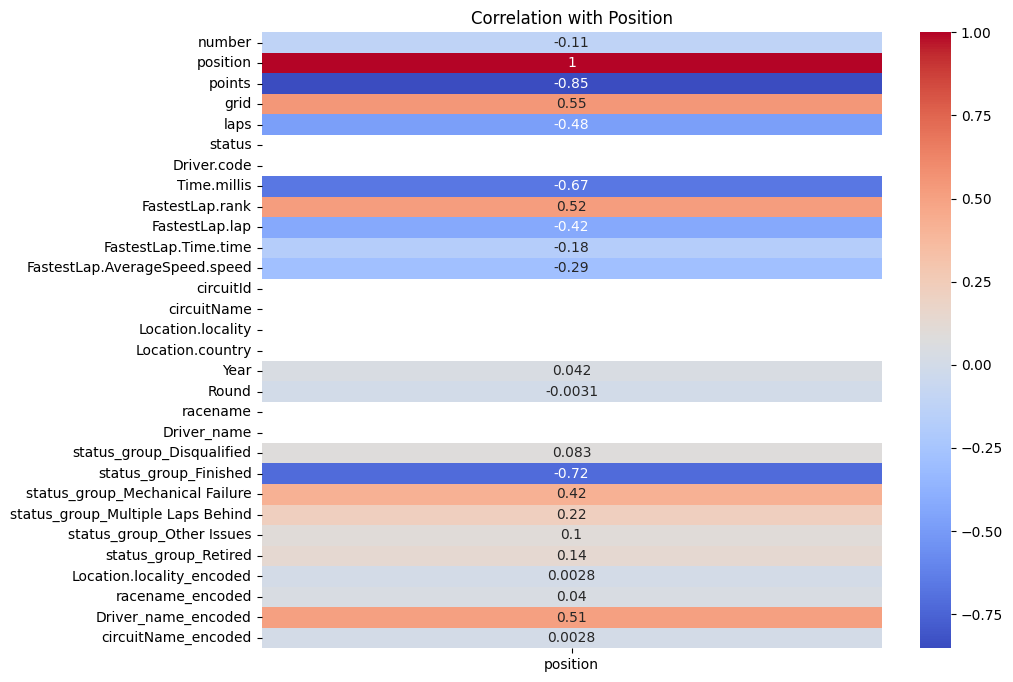

In [ ]:
df_cleaned['position'] = pd.to_numeric(df_cleaned['position'], errors='coerce')
for col in df_cleaned.columns:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

correlation_matrix = df_cleaned.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[['position']], annot=True, cmap='coolwarm')
plt.title('Correlation with Position')
plt.show()

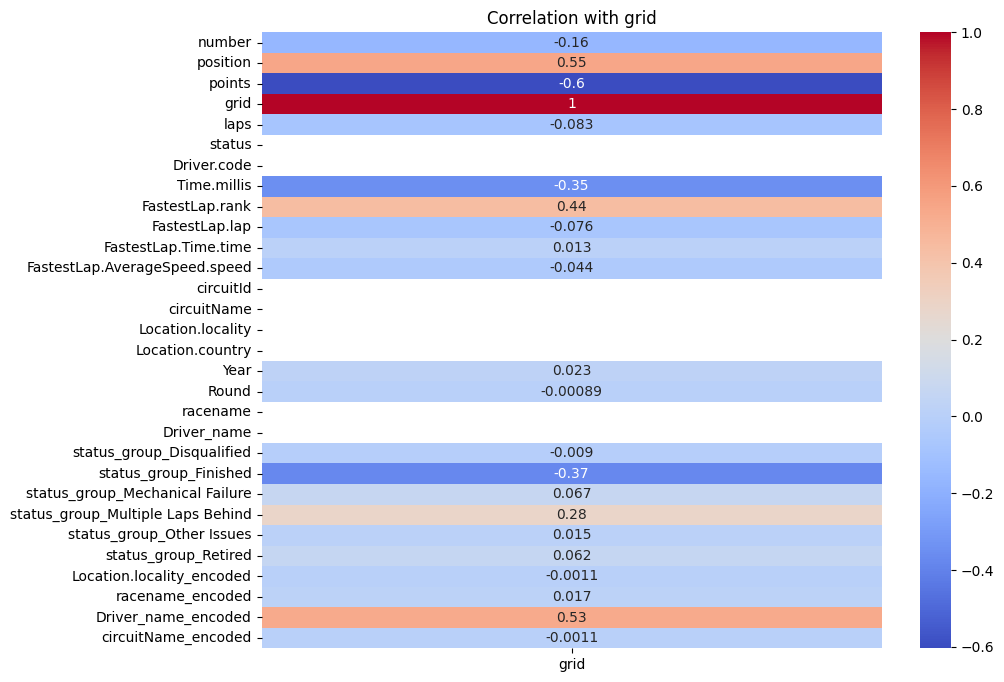

In [ ]:
df_cleaned['grid'] = pd.to_numeric(df_cleaned['grid'], errors='coerce')
for col in df_cleaned.columns:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

correlation_matrix = df_cleaned.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[['grid']], annot=True, cmap='coolwarm')
plt.title('Correlation with grid')
plt.show()

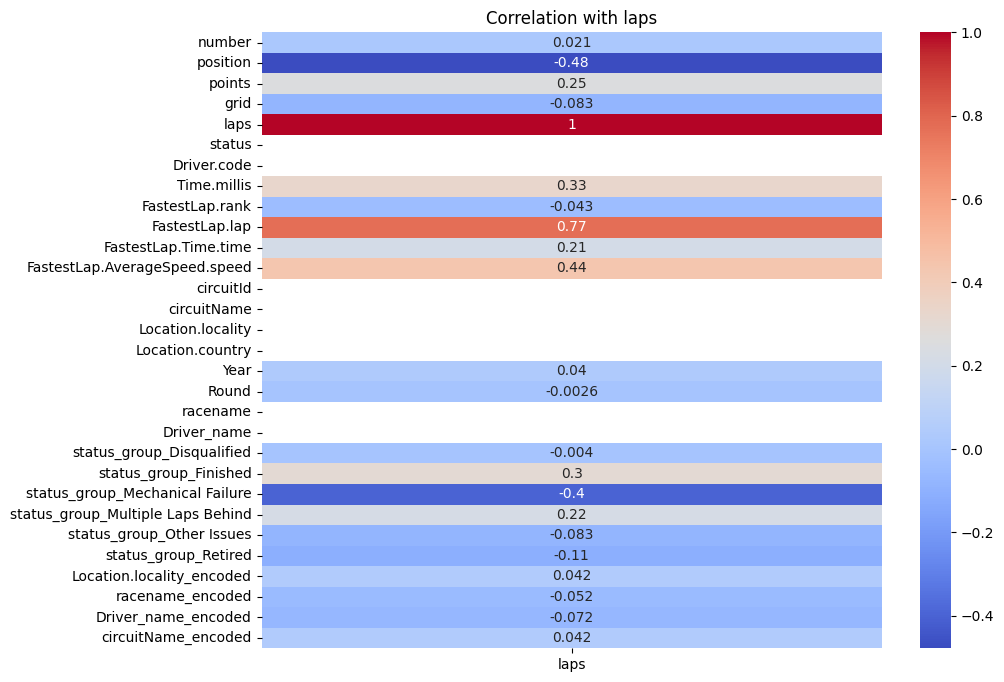

In [ ]:
df_cleaned['laps'] = pd.to_numeric(df_cleaned['laps'], errors='coerce')
for col in df_cleaned.columns:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

correlation_matrix = df_cleaned.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[['laps']], annot=True, cmap='coolwarm')
plt.title('Correlation with laps')
plt.show()

The following graphs show, how different features are related with one another

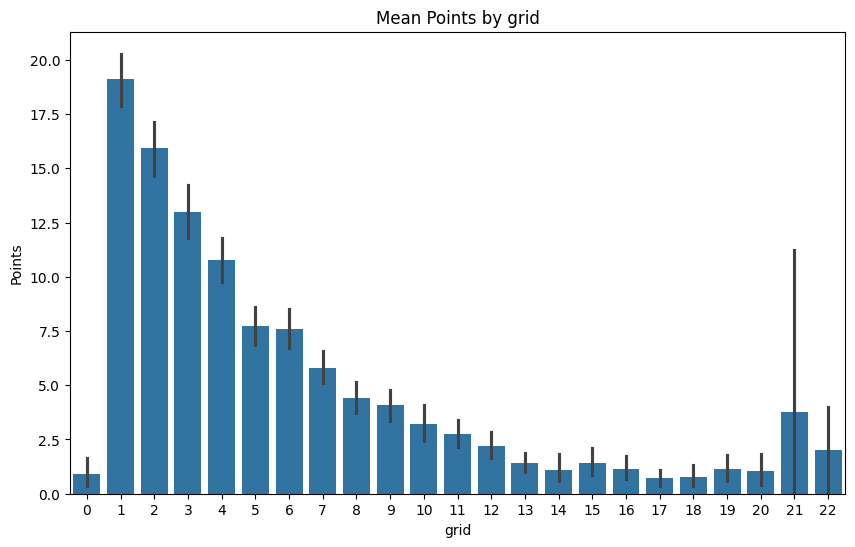

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='grid', y='points', data=df_cleaned, estimator='mean')

plt.title('Mean Points by grid')
plt.xlabel('grid')
plt.ylabel('Points')

plt.show()

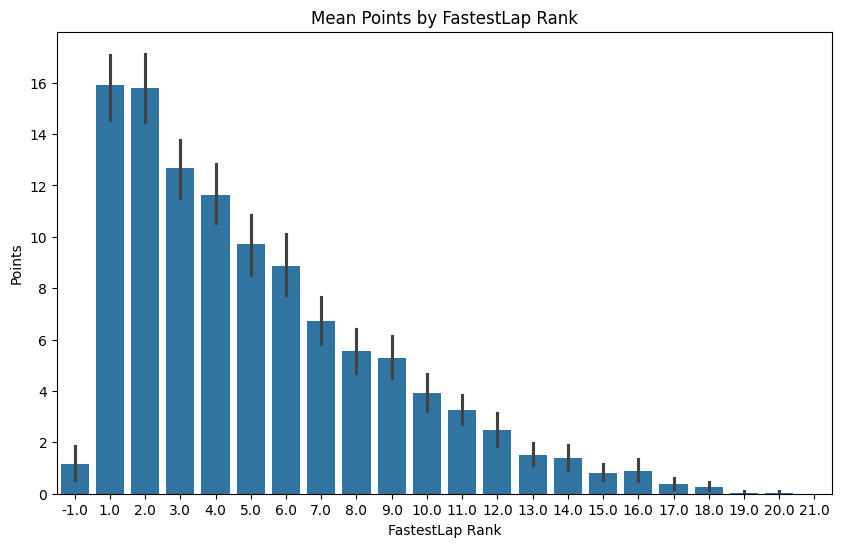

In [ ]:

plt.figure(figsize=(10, 6))
sns.barplot(x='FastestLap.rank', y='points', data=df_cleaned)

plt.title('Mean Points by FastestLap Rank')
plt.xlabel('FastestLap Rank')
plt.ylabel('Points')

plt.show()

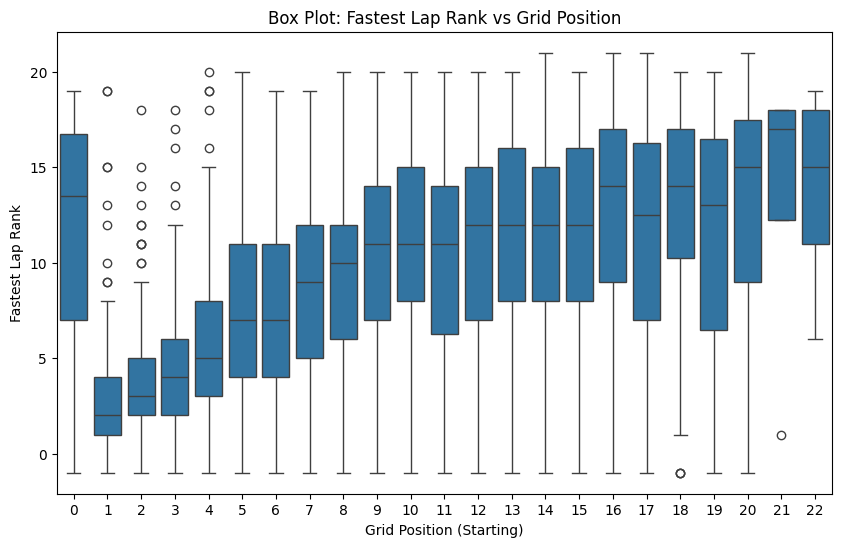

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='grid', y='FastestLap.rank', data=df_cleaned)
plt.title('Box Plot: Fastest Lap Rank vs Grid Position')
plt.xlabel('Grid Position (Starting)')
plt.ylabel('Fastest Lap Rank')
plt.show()

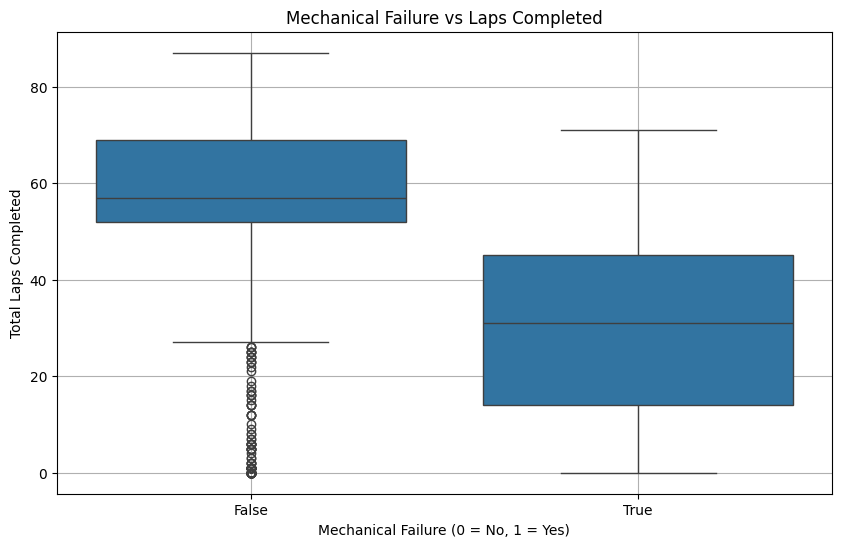

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x='status_group_Mechanical Failure', y='laps', data=df_cleaned)
plt.title('Mechanical Failure vs Laps Completed')
plt.xlabel('Mechanical Failure (0 = No, 1 = Yes)')
plt.ylabel('Total Laps Completed')
plt.grid(True)
plt.show()

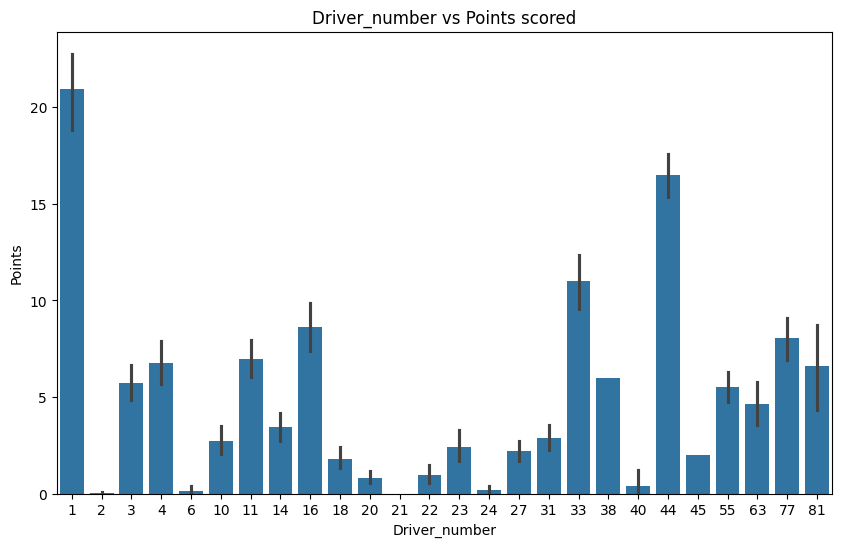

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='number', y='points', data=df_cleaned)

plt.title('Driver_number vs Points scored')
plt.xlabel('Driver_number')
plt.ylabel('Points')

plt.show()

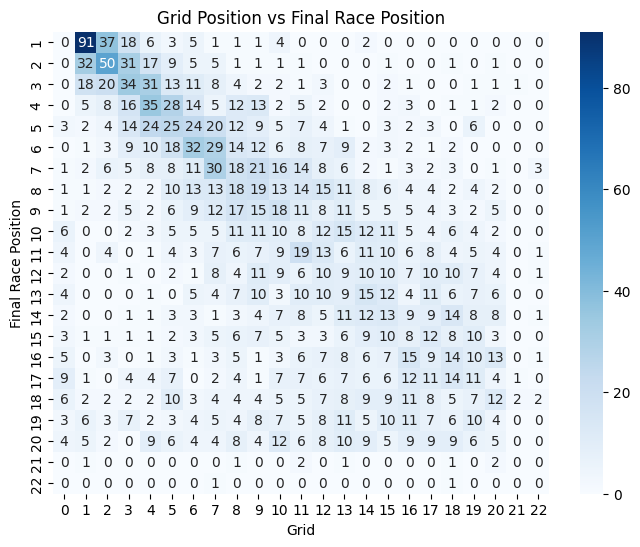

In [ ]:
grid_position_ct = pd.crosstab(df_cleaned['position'],df_cleaned['grid'])
plt.figure(figsize=(8,6))
sns.heatmap(grid_position_ct, cmap='Blues', annot=True, fmt="d")
plt.title('Grid Position vs Final Race Position')
plt.xlabel('Grid')
plt.ylabel('Final Race Position')
plt.show()


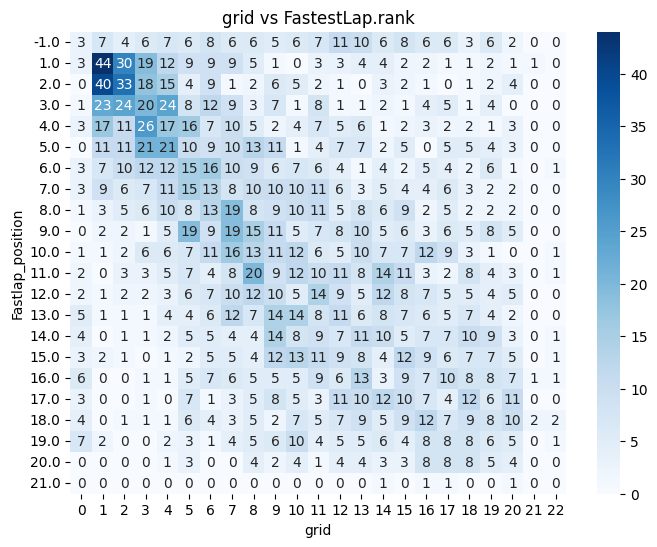

In [ ]:
fastlap_position_ct_1 = pd.crosstab(df_cleaned['FastestLap.rank'],df_cleaned['grid'])
plt.figure(figsize=(8,6))
sns.heatmap(fastlap_position_ct_1, cmap='Blues', annot=True, fmt="d")
plt.title('grid vs FastestLap.rank')
plt.xlabel('grid')
plt.ylabel('Fastlap_position')
plt.show()

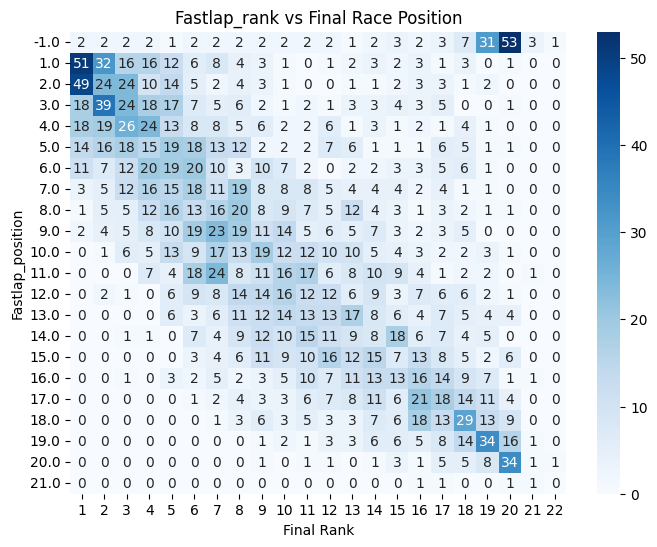

In [ ]:
fastlap_position_ct = pd.crosstab(df_cleaned['FastestLap.rank'],df_cleaned['position'])
plt.figure(figsize=(8,6))
sns.heatmap(fastlap_position_ct, cmap='Blues', annot=True, fmt="d")
plt.title('Fastlap_rank vs Final Race Position')
plt.xlabel('Final Rank')
plt.ylabel('Fastlap_position')
plt.show()


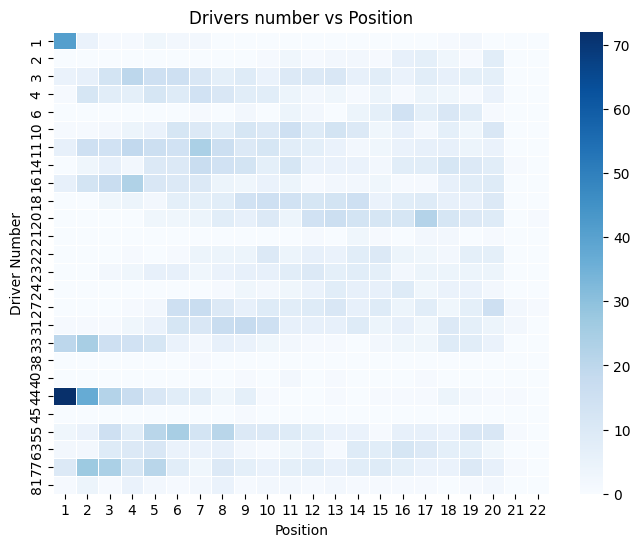

In [ ]:
multivariate_ct_1 = pd.crosstab([df_cleaned['number']], [df_cleaned['position']])
plt.figure(figsize=(8,6))
sns.heatmap(multivariate_ct_1, cmap='Blues', annot=False, linewidths=0.5)

plt.title('Drivers number vs Position')
plt.xlabel('Position')
plt.ylabel('Driver Number')
plt.show()


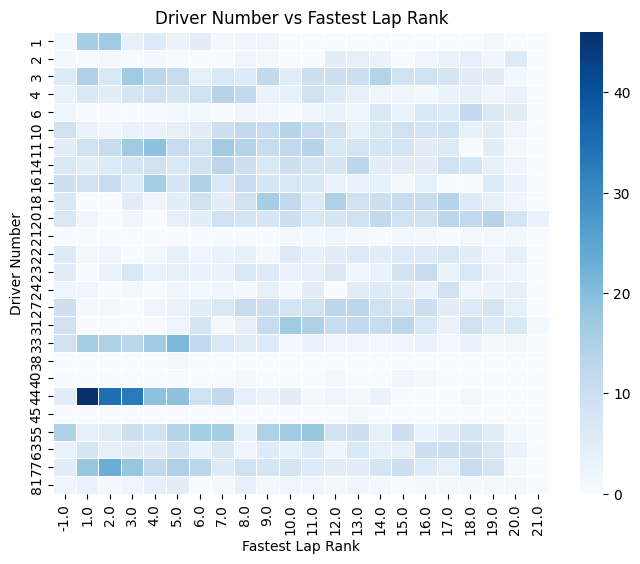

In [ ]:
multivariate_ct_2 = pd.crosstab([df_cleaned['number']], [df_cleaned['FastestLap.rank']])
plt.figure(figsize=(8,6))
sns.heatmap(multivariate_ct_2, cmap='Blues', annot=False, linewidths=0.5)
plt.title('Driver Number vs Fastest Lap Rank')
plt.xlabel('Fastest Lap Rank')
plt.ylabel('Driver Number')
plt.show()

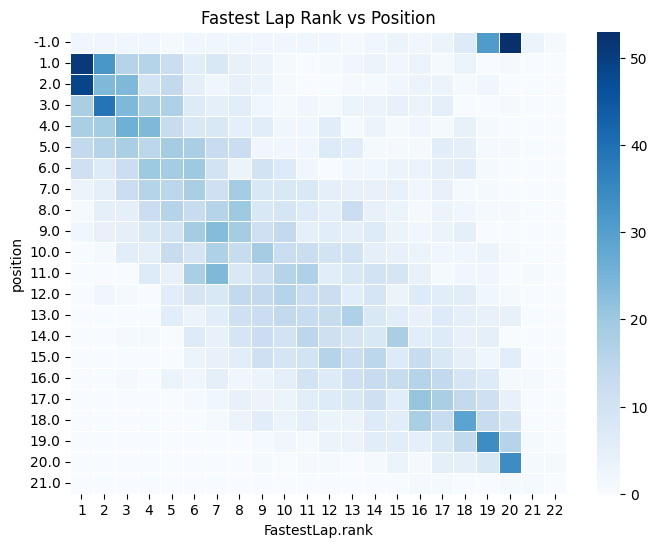

In [ ]:
multivariate_ct_3 = pd.crosstab(df_cleaned['FastestLap.rank'], [df_cleaned['position']])

plt.figure(figsize=(8,6))
sns.heatmap(multivariate_ct_3, cmap='Blues', annot=False, linewidths=0.5)
plt.title('Fastest Lap Rank vs Position')
plt.xlabel('FastestLap.rank')
plt.ylabel('position')
plt.show()

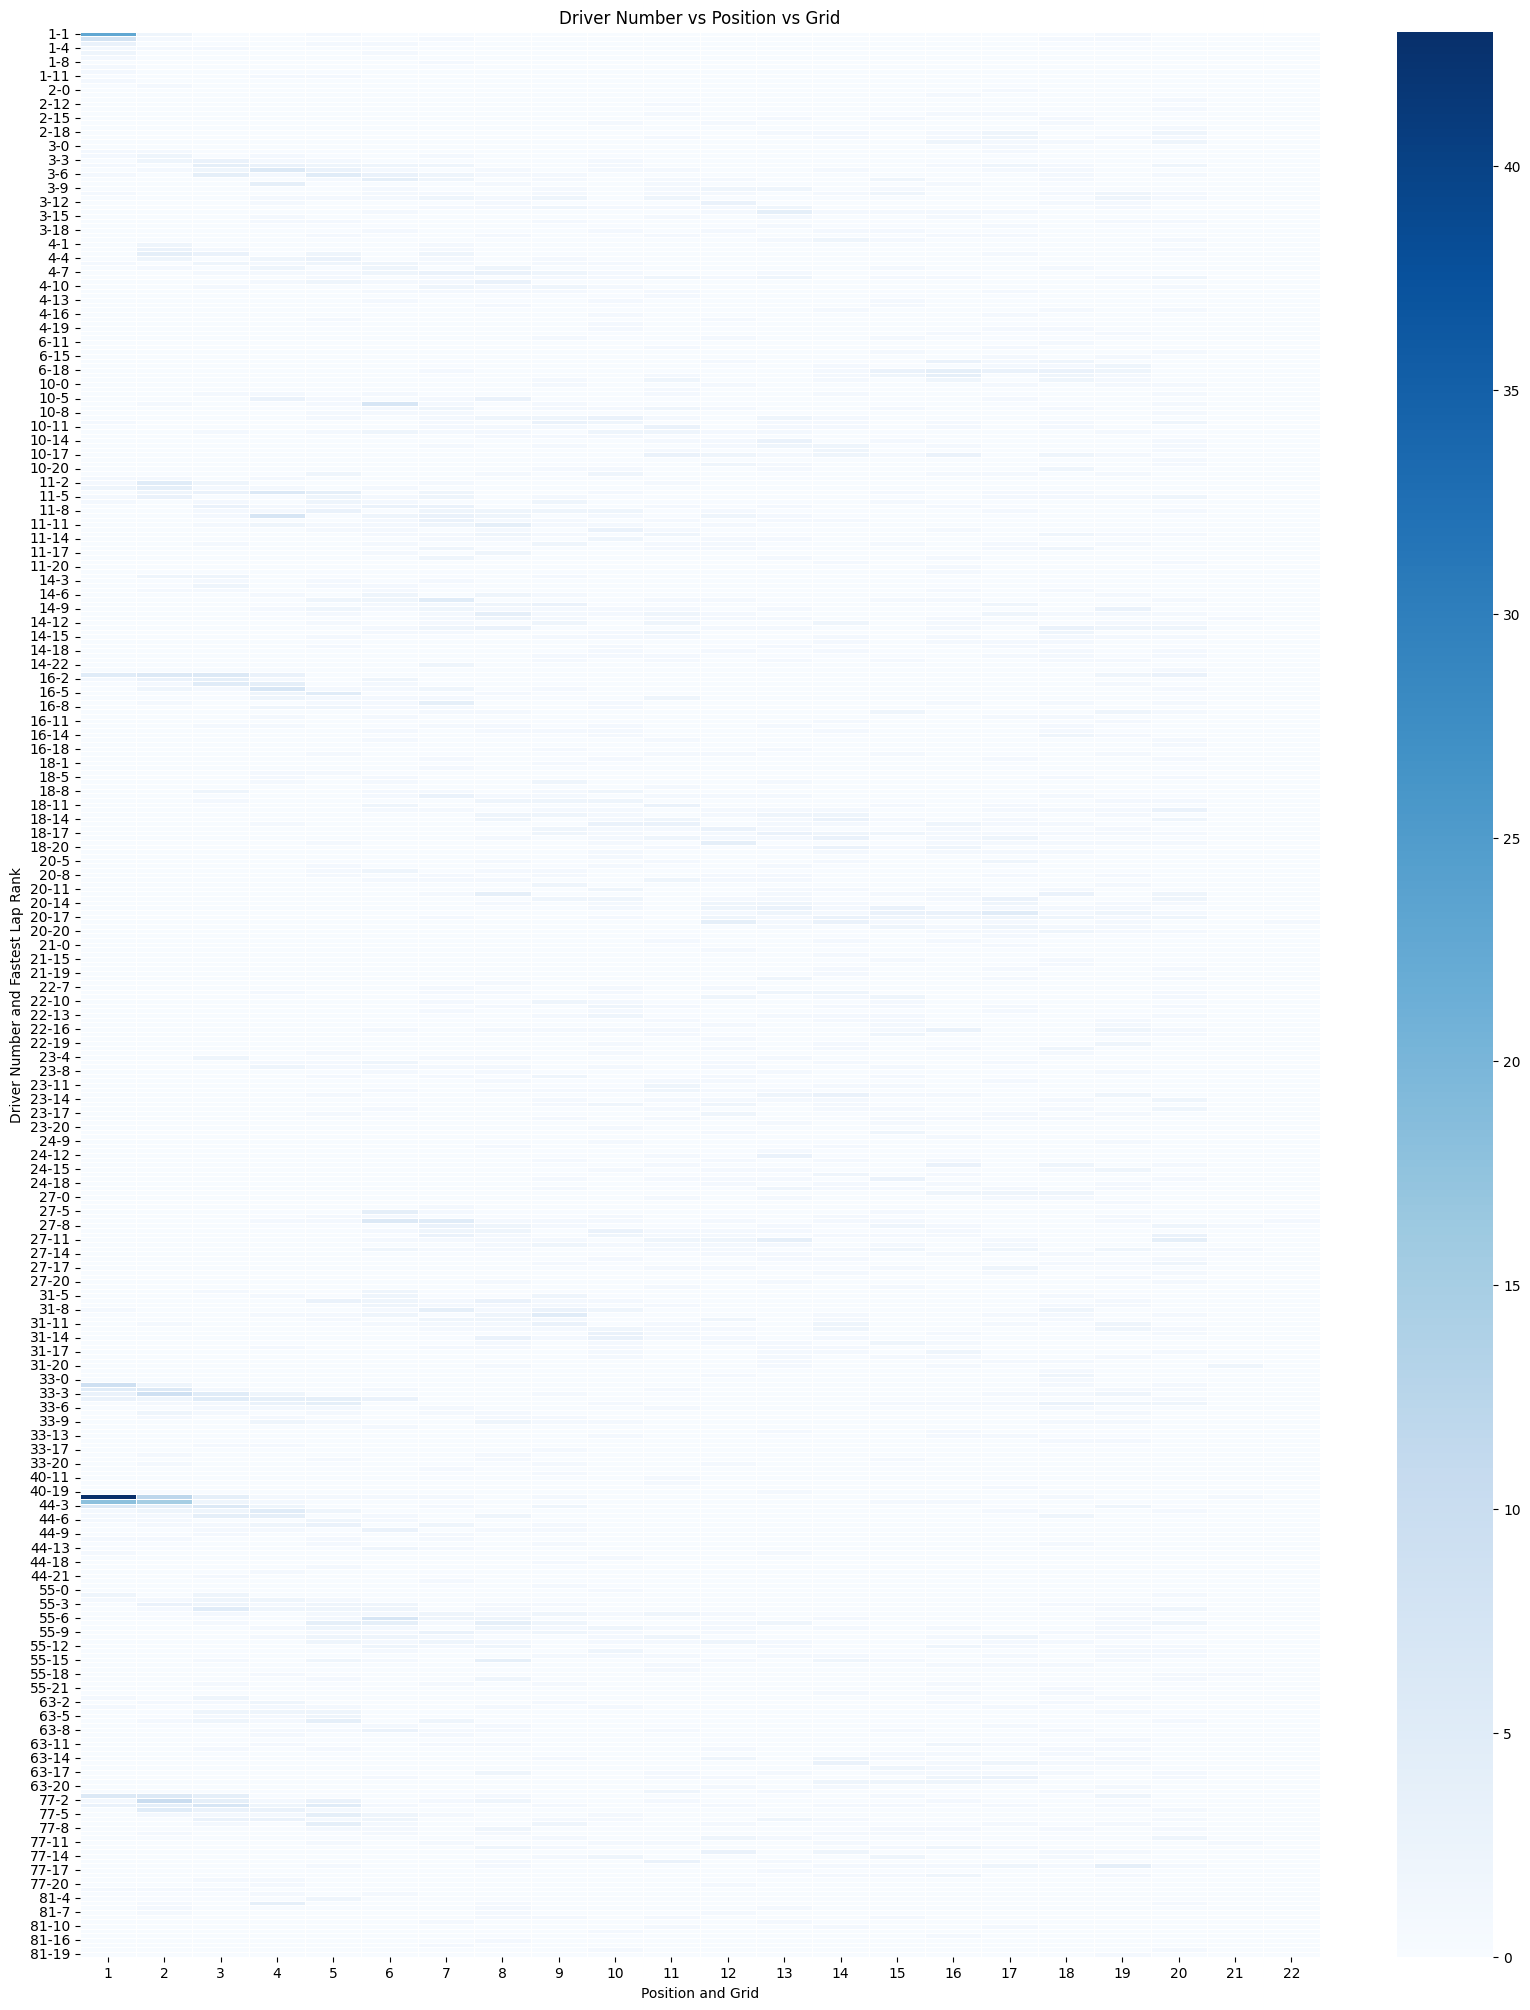

In [ ]:
multivariate_ct = pd.crosstab([df_cleaned['number'], df_cleaned['grid']], [df_cleaned['position']])

# Plot heatmap
plt.figure(figsize=(20,25))
sns.heatmap(multivariate_ct, cmap='Blues', annot=False, linewidths=0.5)

# Set titles and labels
plt.title('Driver Number vs Position vs Grid')
plt.xlabel('Position and Grid')
plt.ylabel('Driver Number and Fastest Lap Rank')
plt.show()

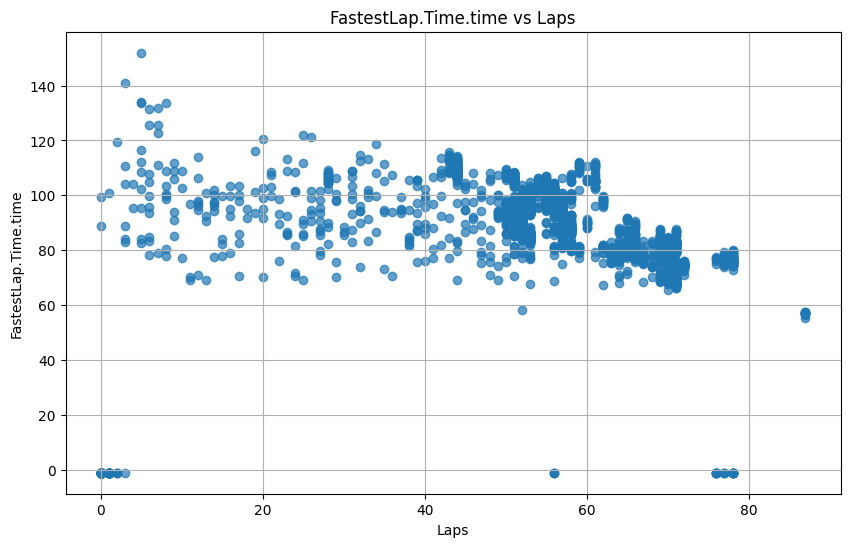

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(df_cleaned['laps'], df_cleaned['FastestLap.Time.time'], alpha=0.7)
plt.title('FastestLap.Time.time vs Laps')
plt.xlabel('Laps')
plt.ylabel('FastestLap.Time.time')
plt.grid(True)
plt.show()

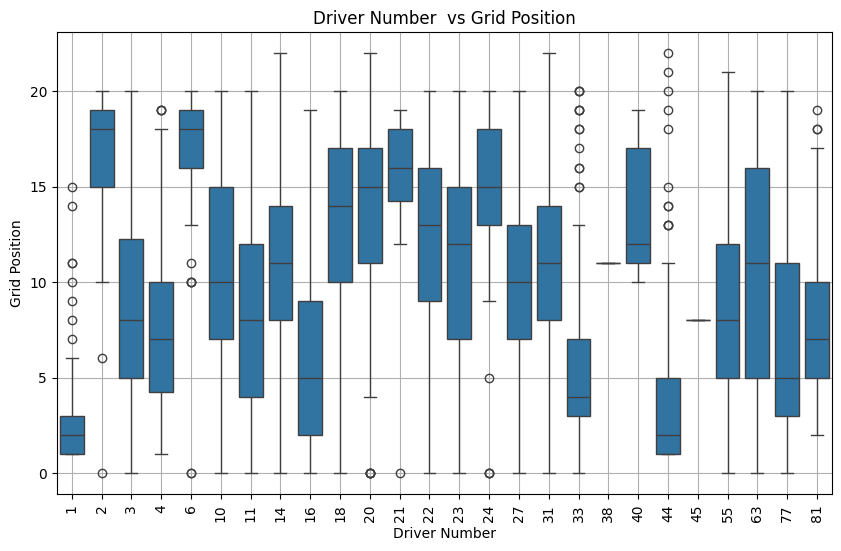

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x='number', y='grid', data=df_cleaned)
plt.title('Driver Number  vs Grid Position')
plt.xlabel('Driver Number')
plt.ylabel('Grid Position')
plt.xticks(rotation = 90)
plt.grid(True)
plt.show()

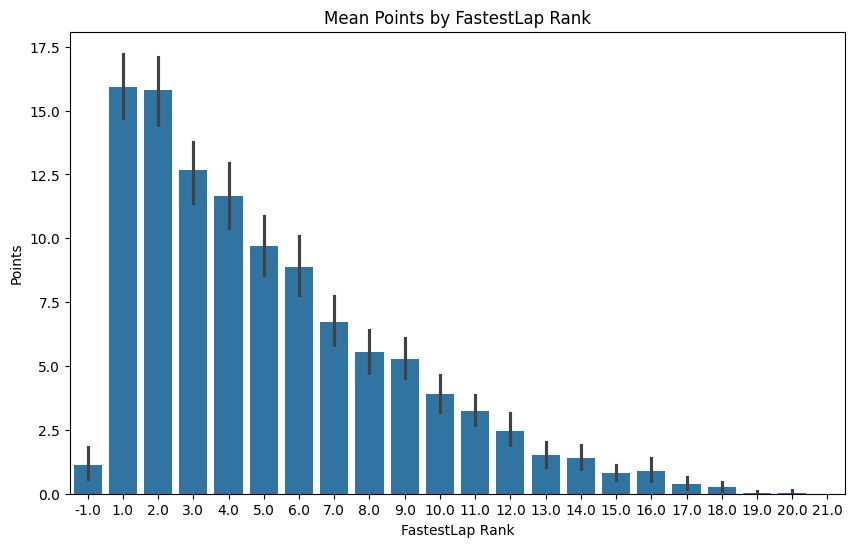

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='FastestLap.rank', y='points', data=df_cleaned)

plt.title('Mean Points by FastestLap Rank')
plt.xlabel('FastestLap Rank')
plt.ylabel('Points')

plt.show()

# *Splitting the dataset into train_val_test for all models*

In [ ]:
cat_col = df_cleaned.select_dtypes(include=['object']).columns.tolist()
cat_col

['status',
 'Driver.code',
 'circuitId',
 'circuitName',
 'Location.locality',
 'Location.country',
 'racename',
 'Driver_name']

In [ ]:
#dividing into (train+val) and test
X_train_val, X_test, y_train_val, y_test = train_test_split(df_cleaned.drop('position', axis=1), df_cleaned['position'], test_size=0.2, random_state=42)

#split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

X_train = X_train.drop(columns=cat_col, axis=1)
X_val = X_val.drop(columns=cat_col, axis=1)
X_test = X_test.drop(columns=cat_col, axis=1)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 1704 samples
Validation set size: 568 samples
Test set size: 569 samples


In [ ]:
lst = X_train.columns
lst

Index(['number', 'points', 'grid', 'laps', 'Time.millis', 'FastestLap.rank',
       'FastestLap.lap', 'FastestLap.Time.time',
       'FastestLap.AverageSpeed.speed', 'Year', 'Round',
       'status_group_Disqualified', 'status_group_Finished',
       'status_group_Mechanical Failure', 'status_group_Multiple Laps Behind',
       'status_group_Other Issues', 'status_group_Retired',
       'Location.locality_encoded', 'racename_encoded', 'Driver_name_encoded',
       'circuitName_encoded'],
      dtype='object')

training the model

# **Psuedo Code**




### Decision Tree Regression :
 1. Start with the entire dataset as the root node.
 2. For each node:
  	 a. If all target values are the same, stop.
  	 b. Otherwise, for each feature:
     i. Calculate the split point that minimizes the mean squared error (MSE).
  	 c. Choose the feature and split point with the lowest MSE.
  	 d. Split the dataset into two subsets based on the chosen split point.
 3. Recursively repeat step 2 for each child node until a stopping criterion is met (e.g.,  maximum depth, minimum samples per leaf).
 4. For each leaf node, assign the average target value of the samples in that node as the prediction.

## Random Forest Regression:
1. Initialize an empty list to store decision trees.
2. For each tree in the forest (total number = n_trees):
  a. Draw a bootstrap sample from the training dataset.
  b. Train a decision tree on the bootstrap sample, selecting a random subset of features for each split.
 c. Add the trained decision tree to the list of trees.
3. To make a prediction for a new sample:
   a. Pass the sample through each decision tree in the forest and get the predicted value.
     b. Average the predictions from all trees to get the final prediction.


##Gradient Boosting Regression:
1. Initialize the model with a constant value (e.g., the mean of the target variable).
2. For each boosting iteration (total number = n_iterations):
   a. Compute the residual errors (differences between actual target values and current model predictions).
   b. Train a new decision tree to predict the residual errors.
    c. Update the model by adding the predictions of the new tree, scaled by a learning rate (shrinkage factor).
3. Continue until the maximum number of boosting iterations is reached or the model converges.
4. To make a prediction for a new sample, sum the initial prediction and all subsequent adjustments made by the trees.


# Pipeline

In [ ]:
# Define pipelines with preprocessing and model
pipelines = {
    'decision_tree': Pipeline([
        ('scaler', StandardScaler()),
        ('model', DecisionTreeRegressor(random_state=42))
    ]),
    'random_forest': Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(random_state=42))
    ]),
    'gradient_boosting': Pipeline([
        ('scaler', StandardScaler()),
        ('model', GradientBoostingRegressor(random_state=42))
    ])
}

# Train each pipeline
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    print(f"{name} pipeline fitted.")

# Validation set evaluation
for name, pipeline in pipelines.items():
    val_score = pipeline.score(X_val, y_val)
    print(f"{name} validation R^2 score: {val_score}")

# Test set evaluation
for name, pipeline in pipelines.items():
    test_score = pipeline.score(X_test, y_test)
    print(f"{name} test R^2 score: {test_score}")

decision_tree pipeline fitted.
random_forest pipeline fitted.
gradient_boosting pipeline fitted.
decision_tree validation R^2 score: 0.9168662347172399
random_forest validation R^2 score: 0.952448560310707
gradient_boosting validation R^2 score: 0.9533356517358299
decision_tree test R^2 score: 0.9165922502974655
random_forest test R^2 score: 0.9559798478195249
gradient_boosting test R^2 score: 0.9545531883322824


In [ ]:
# Defining parameter grids
rf_param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

gb_param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.05],
    'model__max_depth': [3, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV for Random Forest and Gradient Boosting
rf_grid_search = GridSearchCV(pipelines['random_forest'], param_grid=rf_param_grid,
                              cv=5, n_jobs=-1, scoring='r2', verbose=2)

gb_grid_search = GridSearchCV(pipelines['gradient_boosting'], param_grid=gb_param_grid,
                              cv=5, n_jobs=-1, scoring='r2', verbose=2)

# Fit GridSearchCV
rf_grid_search.fit(X_train, y_train)
gb_grid_search.fit(X_train, y_train)

# Print best parameters
print(f"Best Random Forest Parameters: {rf_grid_search.best_params_}")
print(f"Best Random Forest R² Score: {rf_grid_search.best_score_}")

print(f"Best Gradient Boosting Parameters: {gb_grid_search.best_params_}")
print(f"Best Gradient Boosting R² Score: {gb_grid_search.best_score_}")

# Use the best models to predict and evaluate on validation and test sets
rf_best_model = rf_grid_search.best_estimator_
gb_best_model = gb_grid_search.best_estimator_

# Predictions for validation and test sets
rf_val_pred = rf_best_model.predict(X_val)
rf_test_pred = rf_best_model.predict(X_test)

gb_val_pred = gb_best_model.predict(X_val)
gb_test_pred = gb_best_model.predict(X_test)

# Evaluate Random Forest
rf_val_r2 = r2_score(y_val, rf_val_pred)
rf_test_r2 = r2_score(y_test, rf_test_pred)

print(f"Random Forest Validation R²: {rf_val_r2}")
print(f"Random Forest Test R²: {rf_test_r2}")

# Evaluate Gradient Boosting
gb_val_r2 = r2_score(y_val, gb_val_pred)
gb_test_r2 = r2_score(y_test, gb_test_pred)

print(f"Gradient Boosting Validation R²: {gb_val_r2}")
print(f"Gradient Boosting Test R²: {gb_test_r2}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Random Forest Parameters: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 100}
Best Random Forest R² Score: 0.9529133745816398
Best Gradient Boosting Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Best Gradient Boosting R² Score: 0.9549721723778795
Random Forest Validation R²: 0.9527389162747214
Random Forest Test R²: 0.9560442426916806
Gradient Boosting Validation R²: 0.9531102130588084
Gradient Boosting Test R²: 0.9540938651985433


# Evaluation

In [ ]:
# Define a function to evaluate models using evaluating metrics
def evaluate_model(model, X_val, y_val, X_test, y_test):
    # Predict on validation and test sets
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Evaluation metrics
    metrics = {}
    metrics['Mean Squared Error (Validation)'] = mean_squared_error(y_val, y_val_pred)
    metrics['Mean Absolute Error (Validation)'] = mean_absolute_error(y_val, y_val_pred)
    metrics['R^2 Score (Validation)'] = r2_score(y_val, y_val_pred)
    metrics['Explained Variance Score (Validation)'] = explained_variance_score(y_val, y_val_pred)
    metrics['Median Absolute Error (Validation)'] = median_absolute_error(y_val, y_val_pred)

    metrics['Mean Squared Error (Test)'] = mean_squared_error(y_test, y_test_pred)
    metrics['Mean Absolute Error (Test)'] = mean_absolute_error(y_test, y_test_pred)
    metrics['R^2 Score (Test)'] = r2_score(y_test, y_test_pred)
    metrics['Explained Variance Score (Test)'] = explained_variance_score(y_test, y_test_pred)
    metrics['Median Absolute Error (Test)'] = median_absolute_error(y_test, y_test_pred)

    return metrics

# Evaluate the original Decision Tree
dt_metrics = evaluate_model(pipelines['decision_tree'], X_val, y_val, X_test, y_test)

# Evaluate the best Random Forest from GridSearchCV
rf_metrics = evaluate_model(rf_best_model, X_val, y_val, X_test, y_test)

# Evaluate the best Gradient Boosting from GridSearchCV
gb_metrics = evaluate_model(gb_best_model, X_val, y_val, X_test, y_test)

# Print the results
print("Decision Tree Metrics:")
for metric, value in dt_metrics.items():
    print(f"{metric}: {value}")

print("\nBest Random Forest Metrics:")
for metric, value in rf_metrics.items():
    print(f"{metric}: {value}")

print("\nBest Gradient Boosting Metrics:")
for metric, value in gb_metrics.items():
    print(f"{metric}: {value}")


Decision Tree Metrics:
Mean Squared Error (Validation): 2.7799295774647885
Mean Absolute Error (Validation): 0.8503521126760564
R^2 Score (Validation): 0.9168662347172399
Explained Variance Score (Validation): 0.9169797836545146
Median Absolute Error (Validation): 0.0
Mean Squared Error (Test): 2.790861159929701
Mean Absolute Error (Test): 0.843585237258348
R^2 Score (Test): 0.9165922502974655
Explained Variance Score (Test): 0.9166454202317138
Median Absolute Error (Test): 0.0

Best Random Forest Metrics:
Mean Squared Error (Validation): 1.58037452127995
Mean Absolute Error (Validation): 0.6676245239854564
R^2 Score (Validation): 0.9527389162747214
Explained Variance Score (Validation): 0.9527525143480933
Median Absolute Error (Validation): 0.0
Mean Squared Error (Test): 1.4707795890021111
Mean Absolute Error (Test): 0.6239899137137765
R^2 Score (Test): 0.9560442426916806
Explained Variance Score (Test): 0.9561149303537017
Median Absolute Error (Test): 0.0

Best Gradient Boosting Metr

# Saving the best model

The Gradient Boosting Regressor has the best performance across all key metrics, including R² score, MSE, and MAE

In [ ]:
# Save the best Gradient Boosting model
joblib.dump(gb_best_model, 'best_gradient_boosting_model.pkl')

['best_gradient_boosting_model.pkl']

# Loading model for user interaction


In [ ]:
# Load the best Gradient Boosting model
gb_best_model = joblib.load('best_gradient_boosting_model.pkl')

In [ ]:
joblib.dump(status_mapping, 'status_mapping.pkl')
joblib.dump(frequency_encoding, 'frequency_encoding.pkl')
joblib.dump(mean_position_per_race, 'mean_position_per_race.pkl')
joblib.dump(target_encoder, 'target_encoder.pkl')
joblib.dump(circuit_frequency, 'circuit_frequency.pkl')

['circuit_frequency.pkl']

In [ ]:
status_mapping = joblib.load('status_mapping.pkl')
frequency_encoding = joblib.load('frequency_encoding.pkl')
mean_position_per_race = joblib.load('mean_position_per_race.pkl')
target_encoder = joblib.load('target_encoder.pkl')
circuit_frequency = joblib.load('circuit_frequency.pkl')

In [ ]:
def process_user_input(input_data, status_mapping, locality_encoding, mean_position_per_race, target_encoder, circuit_frequency):
    print("Input data:", input_data)  # Debugging line

    user_input = {
        'status': input_data['status'],
        'Location.locality': input_data['Location.locality'],
        'racename': input_data['racename'],
        'Driver_name': input_data['Driver_name'],
        'circuitName': input_data['circuitName'],
        'number': input_data['number'],
        'points': input_data['points']
    }

    print("User input keys:", user_input.keys())  # Debugging line

    # 1. Status Group Mapping
    user_input['status_group'] = status_mapping.get(user_input['status'], 'Other Issues')

    # Convert to one-hot encoding
    status_encoded = {
        'Disqualified': 0,
        'Finished': 0,
        'Mechanical Failure': 0,
        'Multiple Laps Behind': 0,
        'Other Issues': 0,
        'Retired': 0
    }
    if user_input['status_group'] in status_encoded:
        status_encoded[user_input['status_group']] = 1

    # 2. Frequency encoding for Location.locality
    user_input['Location.locality_encoded'] = locality_encoding.get(user_input['Location.locality'], 0)

    # 3. Target encoding for racename
    user_input['racename_encoded'] = mean_position_per_race.get(user_input['racename'], 0)

    # 4. Target encoding for Driver_name
    driver_df = pd.DataFrame({'Driver_name': [user_input['Driver_name']]})
    print(f"Driver DataFrame columns: {driver_df.columns}")  # Debugging line
    print(f"Type of target_encoder: {type(target_encoder)}")
    user_input['Driver_name_encoded'] = target_encoder.transform(driver_df)['Driver_name'][0]

    # 5. Frequency encoding for circuitName
    user_input['circuitName_encoded'] = circuit_frequency.get(user_input['circuitName'], 0)

    # Collect the processed inputs
    processed_input = {
        'number': user_input['number'],
        'points': user_input['points'],
        'status_group_Disqualified': status_encoded['Disqualified'],
        'status_group_Finished': status_encoded['Finished'],
        'status_group_Mechanical Failure': status_encoded['Mechanical Failure'],
        'status_group_Multiple Laps Behind': status_encoded['Multiple Laps Behind'],
        'status_group_Other Issues': status_encoded['Other Issues'],
        'status_group_Retired': status_encoded['Retired'],
        'Location.locality_encoded': user_input['Location.locality_encoded'],
        'racename_encoded': user_input['racename_encoded'],
        'Driver_name_encoded': user_input['Driver_name_encoded'],
        'circuitName_encoded': user_input['circuitName_encoded'],
    }

    return processed_input

def get_user_input():
    # Gather user input
    grid = int(input("Enter the grid position: "))
    laps = int(input("Enter the number of laps: "))
    Time_millis = int(input("Enter time in milliseconds: "))
    FastestLap_rank = int(input("Enter fastest lap rank: "))
    FastestLap_lap = int(input("Enter the lap for fastest lap: "))
    FastestLap_Time_time = float(input("Enter fastest lap time (in seconds): "))
    FastestLap_AverageSpeed_speed = float(input("Enter fastest lap average speed: "))
    Year = int(input("Enter the race year: "))
    number = int(input("Enter the driver number: "))
    points = float(input("Enter the driver's points: "))
    Round = int(input("Enter the round number: "))
    Driver_name = input("Enter driver name: ")
    racename = input("Enter race name: ")
    circuitName = input("Enter circuit name: ")
    Location_locality = input("Enter location locality: ")
    status = input("Enter the status ('Disqualified' or 'Finished' or 'Mechanical Failure' or 'Multiple Laps Behind' or 'Other Issues' or 'Retired'): ")

    user_input = {
        'status': status,
        'Location.locality': Location_locality,
        'racename': racename,
        'Driver_name': Driver_name,
        'circuitName': circuitName,
        'number': number,
        'points': points
    }

    processed_input = process_user_input(user_input, status_mapping, frequency_encoding, mean_position_per_race, target_encoder, circuit_frequency)

    input_data = [
        number, points, grid, laps, Time_millis, FastestLap_rank, FastestLap_lap,
        FastestLap_Time_time, FastestLap_AverageSpeed_speed, Year, Round,
        processed_input['status_group_Disqualified'],
        processed_input['status_group_Finished'],
        processed_input['status_group_Mechanical Failure'],
        processed_input['status_group_Multiple Laps Behind'],
        processed_input['status_group_Other Issues'],
        processed_input['status_group_Retired'],
        processed_input['Location.locality_encoded'],
        processed_input['racename_encoded'],
        processed_input['Driver_name_encoded'],
        processed_input['circuitName_encoded']
    ]

    return input_data

def predict_driver_position():
    input_data = get_user_input()
    input_array = np.array([input_data])
    predicted_position = gb_best_model.predict(input_array)
    rounded_position = round(predicted_position[0])
    print("\n" + "="*30)
    print(f"Predicted driver position: {rounded_position}")
    print("="*30 + "\n")

predict_driver_position()


Enter the grid position: 1
Enter the number of laps: 78
Enter time in milliseconds: 72000000
Enter fastest lap rank: 1
Enter the lap for fastest lap: 55
Enter fastest lap time (in seconds): 82
Enter fastest lap average speed: 150
Enter the race year: 2024
Enter the driver number: 16
Enter the driver's points: 25
Enter the round number: 7
Enter driver name: Charles Leclerc
Enter race name: Monaco Grand Prix
Enter circuit name: Monaco
Enter location locality: Monaco
Enter the status ('Disqualified' or 'Finished' or 'Mechanical Failure' or 'Multiple Laps Behind' or 'Other Issues' or 'Retired'): Finished
Input data: {'status': 'Finished', 'Location.locality': 'Monaco', 'racename': 'Monaco Grand Prix', 'Driver_name': 'Charles Leclerc', 'circuitName': 'Monaco', 'number': 16, 'points': 25.0}
User input keys: dict_keys(['status', 'Location.locality', 'racename', 'Driver_name', 'circuitName', 'number', 'points'])
Driver DataFrame columns: Index(['Driver_name'], dtype='object')
Type of target_en

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
